In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path


DATA_PATH  = '../data/'
SOURCES = ["ng", "bruk"]

---
### Files Distribution

In [2]:
def list_all_leafs(folder_path, extension):
    folder = Path(folder_path)
    leaf_files = [file for file in folder.glob(f'*.{extension}') if file.is_file()]
    return leaf_files

ng_txt_files = list_all_leafs(f'{DATA_PATH}ng/', 'txt')
bruk_txt_files = list_all_leafs(f'{DATA_PATH}bruk/', 'txt')

In [3]:
print("Number of 'Наші гроші' files:", len(ng_txt_files))
print("Number of 'Bідкритий корпус українських текстів' files:", len(bruk_txt_files))

Number of 'Наші гроші' files: 298
Number of 'Bідкритий корпус українських текстів' files: 262


---
### Entity Distribution

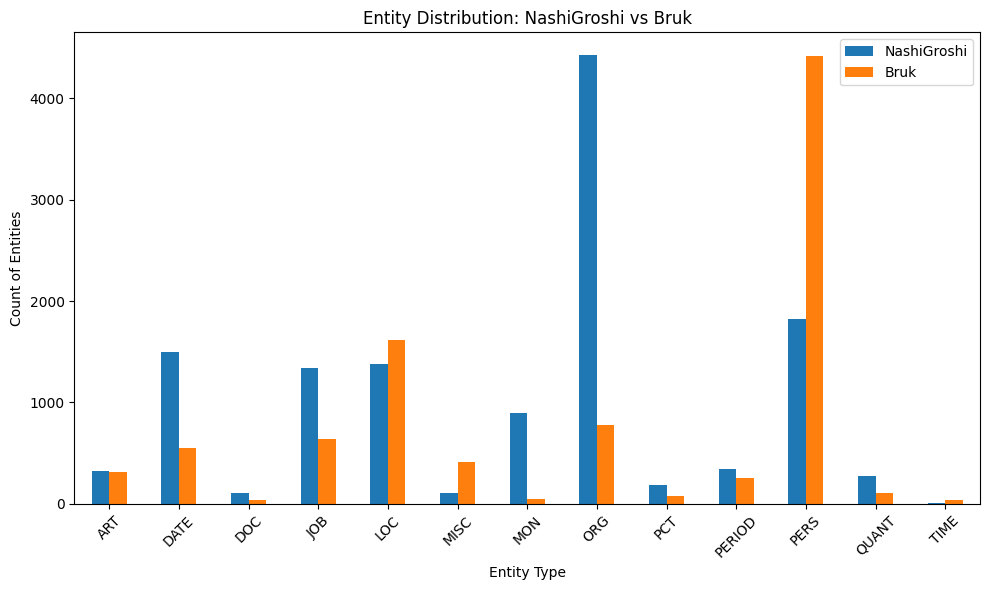

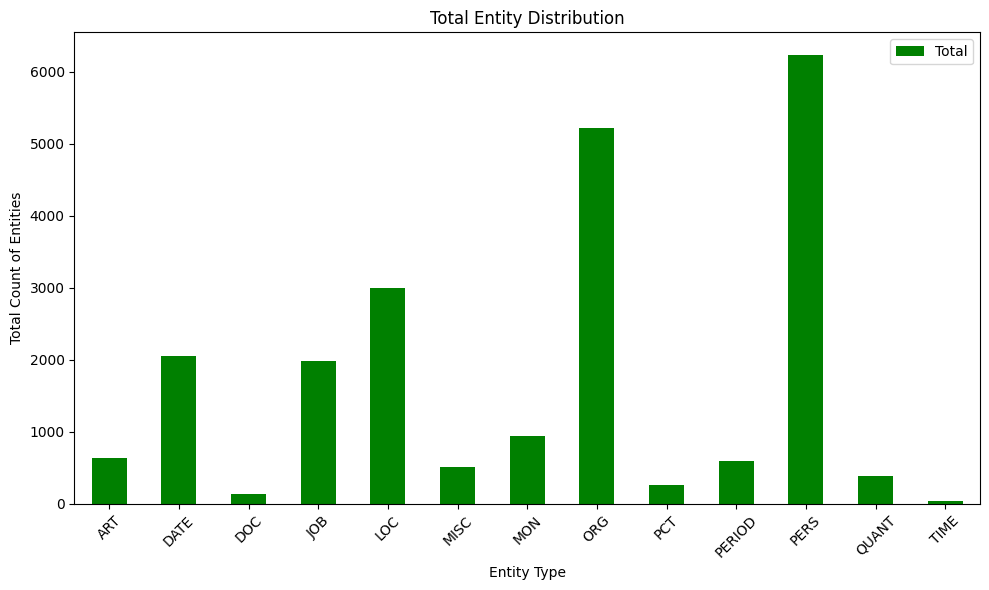

Basic Statistics:
       NashiGroshi         Bruk        Total
count    13.000000    13.000000    13.000000
mean    977.230769   714.538462  1691.769231
std    1212.287105  1195.778311  2002.328193
min       4.000000    34.000000    40.000000
25%     186.000000    77.000000   382.000000
50%     341.000000   316.000000   635.000000
75%    1380.000000   638.000000  2047.000000
max    4431.000000  4415.000000  6235.000000


In [4]:
df = pd.DataFrame({
    'Entity Type': ['ART', 'DATE', 'DOC', 'JOB', 'LOC', 'MISC', 'MON', 'ORG', 'PCT', 'PERIOD', 'PERS', 'QUANT', 'TIME'],
    'NashiGroshi': [319, 1496, 108, 1344, 1380, 102, 897, 4431, 186, 341, 1820, 276, 4],
    'Bruk': [316, 551, 34, 638, 1620, 413, 46, 782, 77, 255, 4415, 106, 36],
    'Total': [635, 2047, 142, 1982, 3000, 515, 943, 5213, 263, 596, 6235, 382, 40]
})

df.set_index('Entity Type')[['NashiGroshi', 'Bruk']].plot(kind='bar', figsize=(10, 6))
plt.title('Entity Distribution: NashiGroshi vs Bruk')
plt.ylabel('Count of Entities')
plt.xlabel('Entity Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df.plot(x='Entity Type', y='Total', kind='bar', color='green', figsize=(10, 6))
plt.title('Total Entity Distribution')
plt.ylabel('Total Count of Entities')
plt.xlabel('Entity Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Basic Statistics:")
print(df.describe())

---
### Missing Annotations

In [5]:
def check_missing_annotations(source):
    print(f"\n--{source}--")
    text_files = list_all_leafs(f'{DATA_PATH}{source}/', 'txt')
    ann_files = list_all_leafs(f'{DATA_PATH}{source}/', 'ann')

    # Convert file lists to sets for easier comparison
    text_base_names = set([os.path.splitext(f)[0] for f in text_files])
    ann_base_names = set([os.path.splitext(f)[0] for f in ann_files])

    # Check for missing .ann files (texts without corresponding annotations)
    missing_ann_files = text_base_names - ann_base_names
    print(f'Missing .ann files for {len(missing_ann_files)} texts:')
    for file in missing_ann_files:
        print(f'- {file}.txt')

    # Check for empty .ann files (annotations exist but are empty)
    empty_ann_files = []
    for ann_file in ann_files:
        with open(ann_file, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            if len(content) == 0:
                empty_ann_files.append(ann_file)

    print(f'Empty .ann files (no annotations) for {len(empty_ann_files)} texts:')
    for file in empty_ann_files:
        print(f'- {file}')


_ = [check_missing_annotations(source) for source in SOURCES]


--ng--
Missing .ann files for 0 texts:
Empty .ann files (no annotations) for 0 texts:

--bruk--
Missing .ann files for 0 texts:
Empty .ann files (no annotations) for 2 texts:
- ../data/bruk/605bc326eeaf.ann
- ../data/bruk/d027e35c242d.ann


---
### Test/Train Split 

In [6]:
with open(f"{DATA_PATH}dev-test-split/test.txt") as test_f, open(f"{DATA_PATH}dev-test-split/train.txt") as train_f:
    train_file_names = [line.strip("\n") for line in train_f.readlines()]
    test_file_names = [line.strip("\n") for line in test_f.readlines()]

In [7]:
def list_all_leafs(folder_path, extension):
    folder = Path(folder_path)
    leaf_files = [str(file) for file in folder.rglob('*') if file.is_file() and file.suffix.lower() == extension]
    return leaf_files

all_annotations = list_all_leafs(f'{DATA_PATH}/', '.ann')

In [8]:
test_files = []
train_files = []

for annotation in all_annotations:
    if annotation[-16:-4] in train_file_names:
        train_files.append(annotation)
    else:
        test_files.append(annotation)

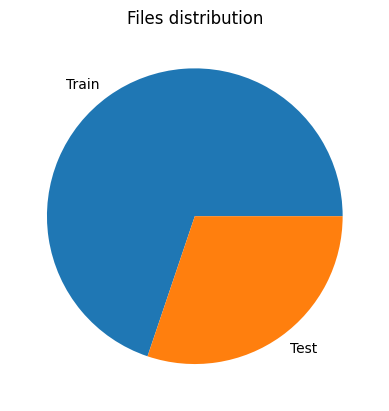

In [9]:
plt.pie([len(train_files), len(test_files)], labels=['Train', 'Test'])
plt.title('Files distribution')
plt.show()

In [10]:
def count_entities_from_paths(ann_paths):
    entity_counts = defaultdict(int)
    for ann_file in ann_paths:
        if os.path.exists(ann_file):
            with open(ann_file, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        entity_type = parts[1]
                        entity_counts[entity_type] += 1
    return entity_counts

# Step 1: Count entities in train and test sets based on provided paths
train_entity_counts = count_entities_from_paths(train_files)
test_entity_counts = count_entities_from_paths(test_files)

# Step 2: Convert entity counts to DataFrames for analysis
train_data = {'Entity Type': list(train_entity_counts.keys()), 'Count': list(train_entity_counts.values())}
test_data = {'Entity Type': list(test_entity_counts.keys()), 'Count': list(test_entity_counts.values())}

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

df_train = df_train[df_train["Count"] > 1]
df_test = df_test[df_test["Count"] > 1]

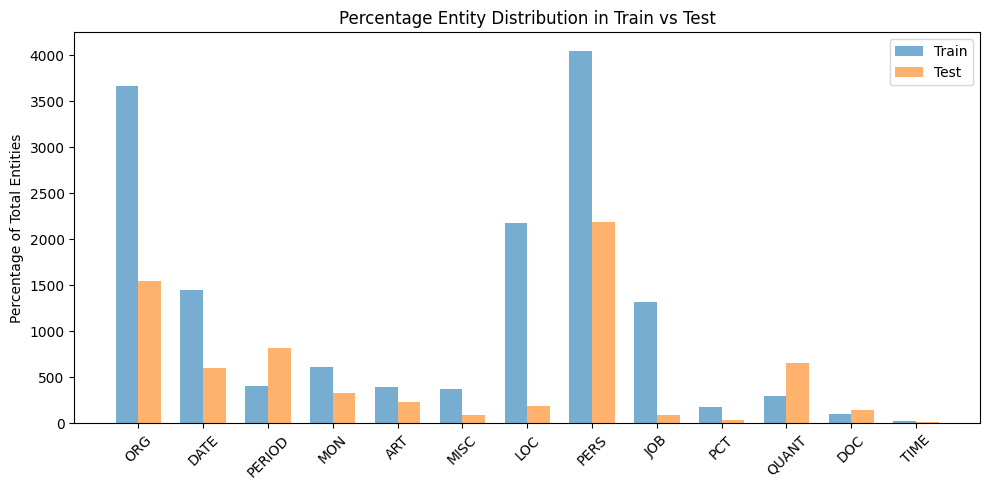

In [11]:
bar_width = 0.35
index = np.arange(len(df_train['Entity Type']))

plt.figure(figsize=(10, 5))

plt.bar(index, df_train['Count'], bar_width, label='Train', alpha=0.6)
plt.bar(index + bar_width, df_test['Count'], bar_width, label='Test', alpha=0.6)

plt.ylabel('Percentage of Total Entities')
plt.title('Percentage Entity Distribution in Train vs Test')
plt.xticks(index + bar_width / 2, df_train['Entity Type'], rotation=45)  # Center the x-ticks
plt.legend()
plt.tight_layout()
plt.show()

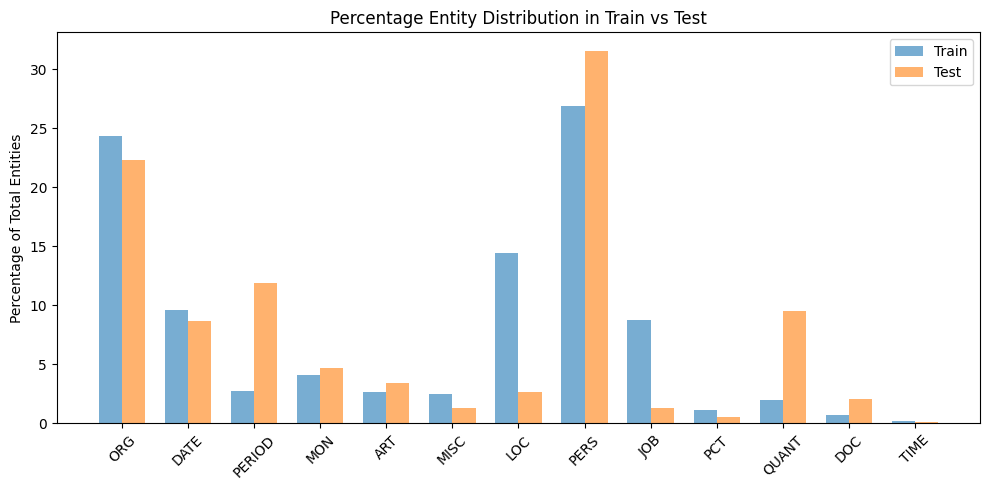

In [12]:
df_train['Percentage'] = (df_train['Count'] / df_train['Count'].sum()) * 100
df_test['Percentage'] = (df_test['Count'] / df_test['Count'].sum()) * 100

# Plot side-by-side bar chart for percentage distribution in train and test sets
bar_width = 0.35
index = np.arange(len(df_train['Entity Type']))

plt.figure(figsize=(10, 5))

# Plot for train
plt.bar(index, df_train['Percentage'], bar_width, label='Train', alpha=0.6)

# Plot for test (shifted by bar_width to appear next to the train bars)
plt.bar(index + bar_width, df_test['Percentage'], bar_width, label='Test', alpha=0.6)

plt.ylabel('Percentage of Total Entities')
plt.title('Percentage Entity Distribution in Train vs Test')
plt.xticks(index + bar_width / 2, df_train['Entity Type'], rotation=45)  # Center the x-ticks
plt.legend()
plt.tight_layout()
plt.show()